# Shor's algorithm in Qiskit


## note on simulator used
Due to many qbits and  long circuits - currently the code is set up to work with  high performance qiskit-air simulator  

https://github.com/Qiskit/qiskit-aer

Before running the notebook please install:

<code>!pip install qiskit-aer</code>

## Preparations

In [1]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.visualization import plot_histogram

In [2]:
import sys
import logging

logging.basicConfig(level=logging.INFO)

for handler in logging.getLogger().handlers:
    handler.setLevel(logging.WARNING)

logger = logging.getLogger('implementations.shor')
logger.setLevel(logging.INFO)

if len(logger.handlers) == 0:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(name)s: %(message)s'))
    handler.addFilter(logging.Filter('implementations.shor'))
    logger.addHandler(handler)

Select numbers to test.

In [3]:
# N = 15, 21; also 35, 55 (for these, simulation will be longer, up to few minutes)
N = 15

# 1 < a < N and gcd(a, N) = 1
a = 7

## Classical calculations

Compute classically reminders of `a^x mod N` for `x = 1, ..., 20`. Present results on graph, observe the period. For modular power, see https://docs.python.org/3.8/library/functions.html#pow

In [4]:
exponents = list(range(20))
values = []

for i in exponents:
    value = pow(a, i, mod=N)
    values.append(value)

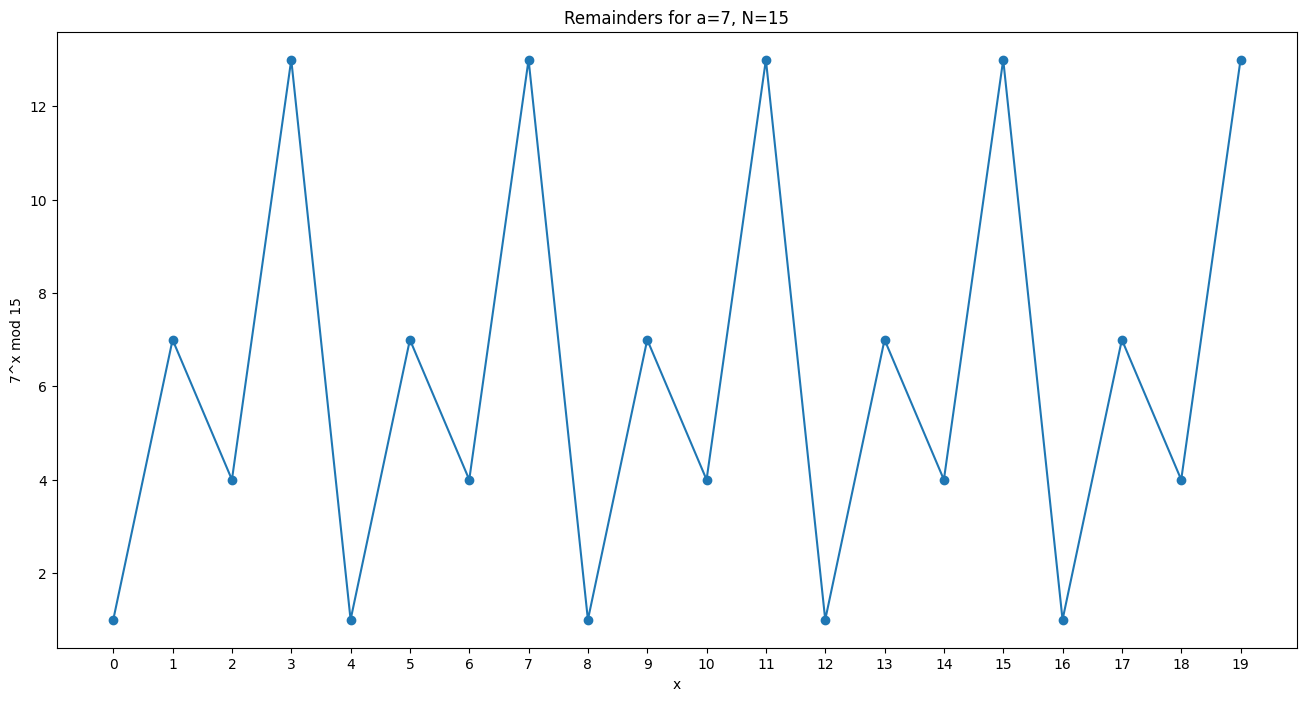

In [5]:
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(exponents)
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

## Operation `a^x mod N` in Qiskit

Import gate for modular exponentiation. You can also use other implementations (mind the number of ancillary qubits).

In [6]:
from gates.mix.modular_exponentiation import modular_exponentiation_gate  # (n + 1 ancilla)

# from gates.takahashi.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla)

# from gates.beauregard.modular_exponentiation import modular_exponentiation_gate # (n + 2 ancilla)

# from gates.haner.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla, big size of circuit!)

Count width `n` of `N`.

In [7]:
n = N.bit_length()
print(n)

4


Create registers and circuit.

In [8]:
# input register
x_qreg = QuantumRegister(2 * n, name='x')

# output register, must contain 1
y_qreg = QuantumRegister(n, name='y')

In [9]:
# ancillary register; change the size according to selected implementation
ancillary_register_size = n + 1
aux_qreg = QuantumRegister(ancillary_register_size, name='aux')

In [10]:
circuit = QuantumCircuit(x_qreg, y_qreg, aux_qreg)

In [11]:
# prepare input register
circuit.h(x_qreg)

# prepare output register
circuit.x(y_qreg[0])

In [12]:
# append gate
gate = modular_exponentiation_gate(a, N, n)
circuit.append(gate, circuit.qubits)

In [13]:
# measure output register
y_creg = ClassicalRegister(n, name='yValue')
circuit.add_register(y_creg)
circuit.measure(y_qreg, y_creg)

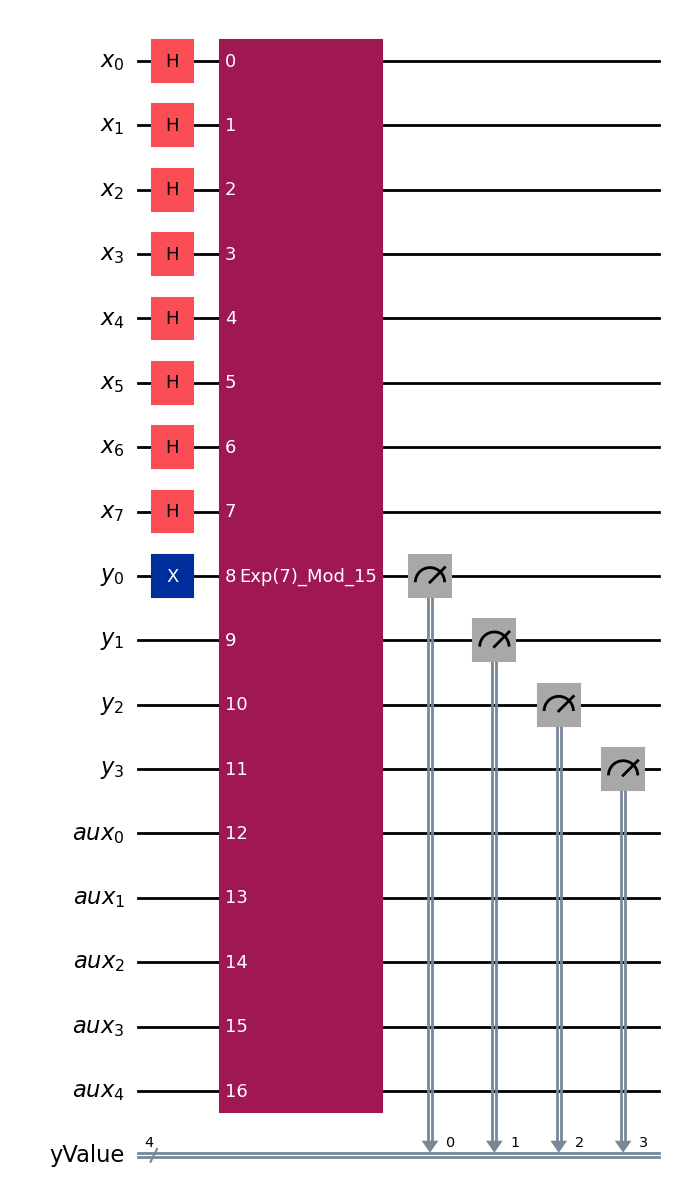

In [14]:
circuit.draw(output='mpl', fold=-1)

Run circuit using AerSimulator


In [15]:
import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#Construct the simulator
aersim = AerSimulator()

In [16]:
pm = generate_preset_pass_manager(backend=aersim, optimization_level=3)
isa_qc = pm.run(circuit)
#run
result = aersim.run(isa_qc, shots=1024).result()
counts = result.get_counts(0)
print('Counts:', counts)

Counts: {'0001': 255, '1101': 245, '0100': 267, '0111': 257}


Draw histogram. Compare results with classical calculations.

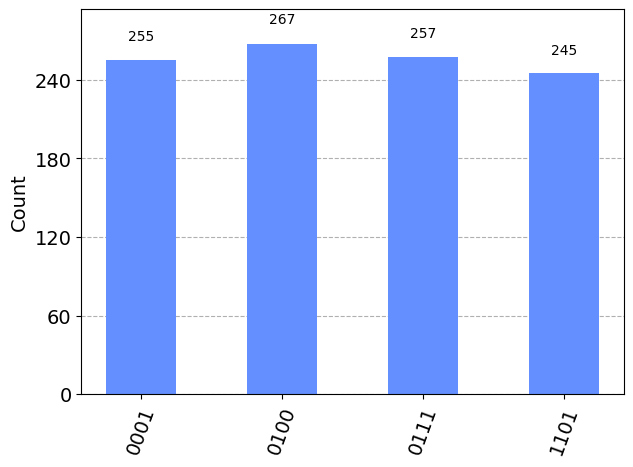

In [17]:
#counts = exponentiation_result.quasi_dists[0].binary_probabilities()
plot_histogram(counts)

Let's try observe period.

In [18]:
# clone circuit
circuit2 = circuit.copy()

# measure input register
x_creg = ClassicalRegister(2 * n, name='xValue')
circuit2.add_register(x_creg)
circuit2.measure(x_qreg, x_creg)

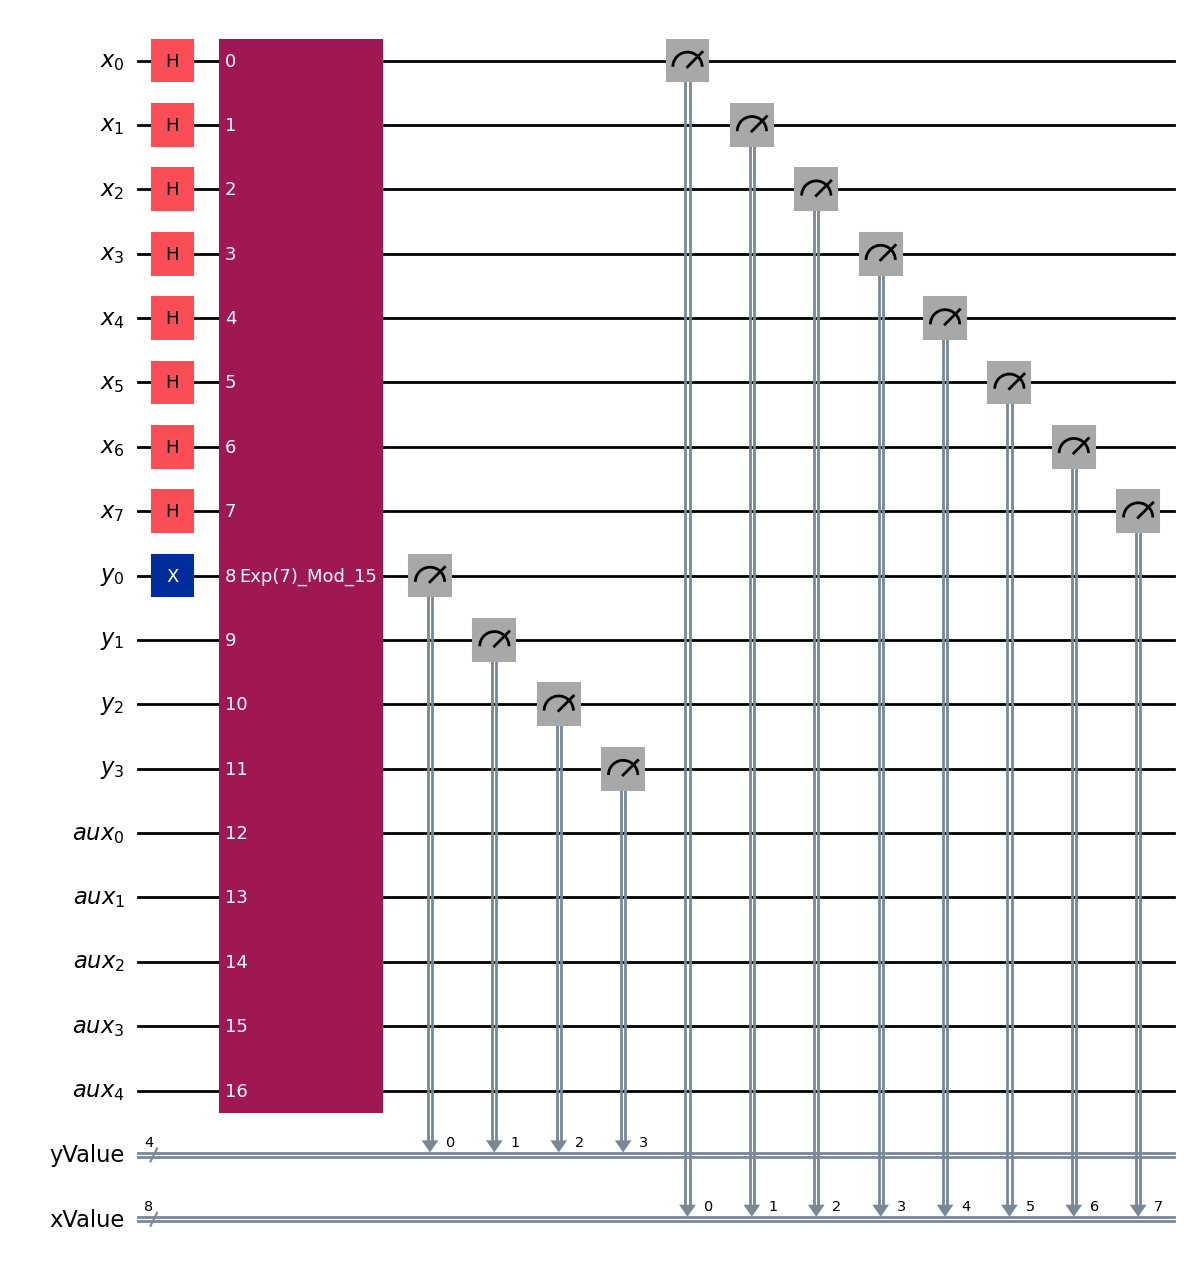

In [19]:
circuit2.draw(output='mpl', fold=-1)

In [20]:
pm = generate_preset_pass_manager(backend=aersim, optimization_level=3)
isa_qc = pm.run(circuit2)
result = aersim.run(isa_qc,shots=1024).result()
counts = result.get_counts(0)

In [21]:
values_map = {}
for measurement in counts.keys():
    s=2*n
    x=int(measurement[:s], base=2)
    y=int(measurement[s:], base=2)
    values = values_map.get(y, [])
    values.append(x)
    values_map[y] = values

Print measured `x` values for each exponentiation result.
You should observe that values differs from each other by constant - period `r`. (precisely, only part of them
in different runs will - think why!)

In [22]:
for y, x_values in values_map.items():
    print(y)
    print(sorted(x_values))
    print()

1
[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 248, 252]

13
[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 115, 119, 123, 127, 131, 135, 139, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207, 211, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255]

4
[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154, 158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206, 210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254]

7
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117,

## Finding period / order in Qiskit

Import Shor's algorithm implementation.
Similarly to modular exponentiation gate, you can test different implementations.

In [23]:
from implementations.mix import MixShor as Shor

# from implementations.takahashi import TakahashiShor as Shor

# from implementations.beauregard import BeauregardShor as Shor

# from implementations.haner import HanerShor as Shor # (big size of circuit!)

For usage, class instance have to be created. The circuits will be run using local qiskit-air simulator.

In [24]:
# create instance of class
shor = Shor(shots=64)

Observe 3 parts of algorithm.

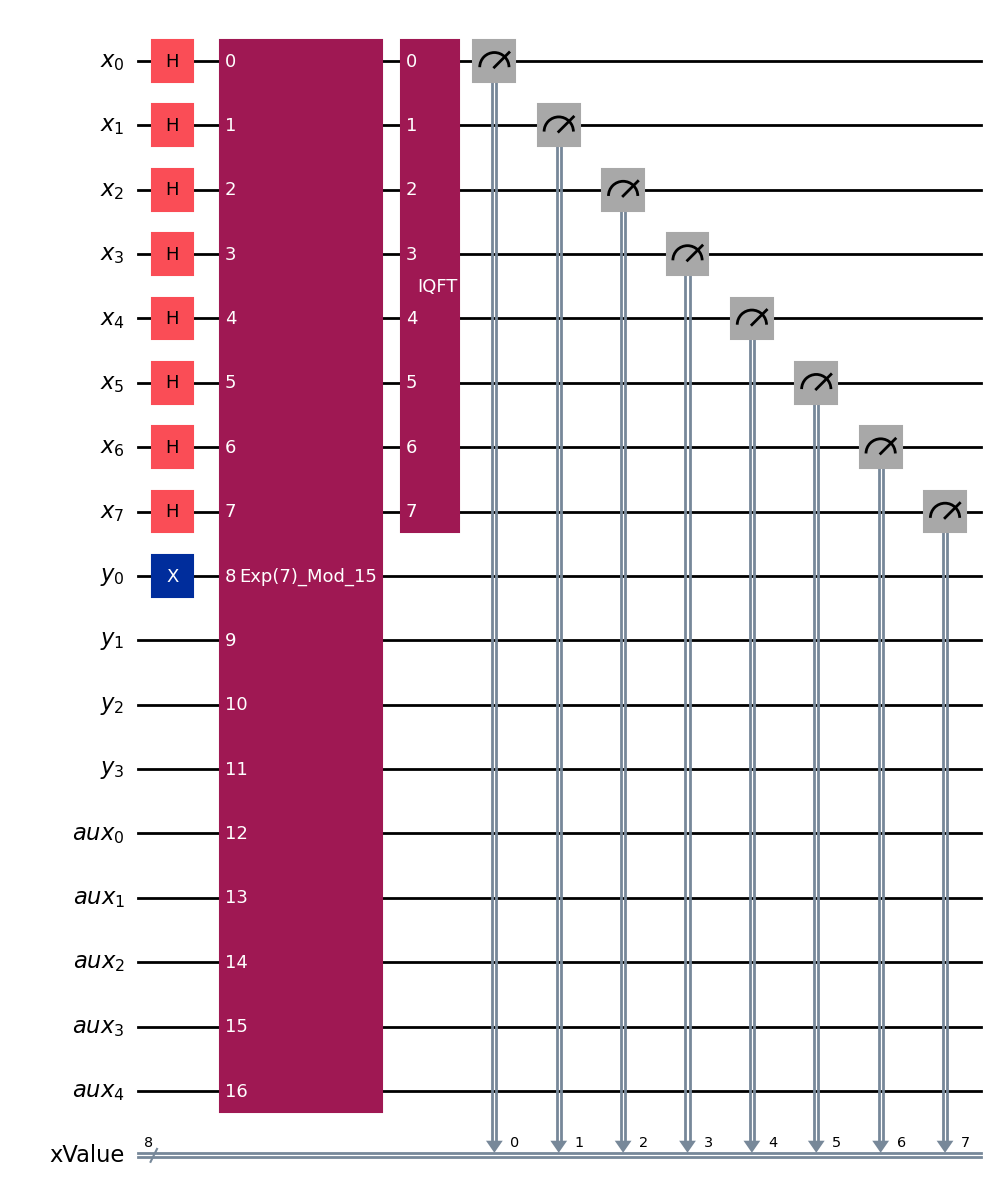

In [25]:
N=15
a=7
circuit = shor.construct_circuit(a, N, semi_classical=False, measurement=True)
circuit.draw(output='mpl', fold=-1)

Invoke `get_order()` to run algorithm and post-process measurements. 
<b>Setting `semi_classical` argument to `True` will run algorithm on optimized version of circuit.</b>

In [26]:
result = shor.get_order(a, N, semi_classical=True)

implementations.shor: Measurement = 64.
implementations.shor: Measured phase = 0.25.
implementations.shor: Fractional approximation: 1/4.
implementations.shor: Success, order: r = 4 from measurement 64.
implementations.shor: Measurement = 192.
implementations.shor: Measured phase = 0.75.
implementations.shor: Fractional approximation: 3/4.
implementations.shor: Success, order: r = 4 from measurement 192.
implementations.shor: Measurement = 128.
implementations.shor: Measured phase = 0.5.
implementations.shor: Fractional approximation: 1/2.
implementations.shor: Denominator 2 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*2 = 4.
implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.


Print result. Compare it with earlier observed order.

In [27]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)

64 50
4 3
4


## Bob's and Eva's algorithm

Use `get_order()` to perform tasks from laboratories.
For modular power and modular inverse see: https://docs.python.org/3/library/functions.html#pow

In [28]:
# TODO by you :)

In [29]:
import qiskit
qiskit.version.get_version_info()

'1.0.2'

In [30]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.22.0'

### Constants

In [59]:
# pubkeys
N = 55
c = 17

# privkeys
p_true, q_true = 11, 5
d_true = 33

# msg
a = 9
b = pow(a, c, mod=N)
print(f"a = {a}\nb = {b}")

a = 9
b = 4


### Eva

1. Znajdujemy rząd zakodowanej wiadomości $b$ w $G_N$ czyli taką liczbę $r$, ze $b * r ≡ 1 \mod N$ (trudne)

In [60]:
def get_order(msg, N, shots=64, semi_classical=True):
    shor = Shor(shots=shots)
    result = shor.get_order(msg, N, semi_classical=semi_classical)
    return result.order

r = get_order(b, N, shots=64, semi_classical=True)
print(f"r = {r}")

implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 3687.
implementations.shor: Measured phase = 0.900146484375.
implementations.shor: Fractional approximation: 9/10.
implementations.shor: Success, order: r = 10 from measurement 3687.
implementations.shor: Measurement = 3686.
implementations.shor: Measured phase = 0.89990234375.
implementations.shor: Fractional approximation: 9/10.
implementations.shor: Success, order: r = 10 from measurement 3686.
implementations.shor: Measurement = 819.
implementations.shor: Measured phase = 0.199951171875.
implementations.shor: Fractional approximation: 1/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*5 = 10.
implementations.shor: Measurement = 1638.
implementations.shor: Measured phase = 0.39990234375.
implementations.shor: F

2. Znajdujemy klucz prywatny $d′$, taki, że $c · d′ ≡ 1 \mod r$. Czyli $c$ oraz $d′$ to odwrotności w $G_r$ (łatwe - np. rozszerzony algorytm Euklidesa)

In [61]:
from egcd import egcd # extended Euclidean algorithm
# When it is supplied two integer arguments a and b, it returns a tuple of the form (g, s, t) 
# where the three integers in the tuple satisfy the identity (a * s) + (b * t) == g == gcd(a, b)

def find_inverse(c: int, r: int):
    # c * d + r * _ = 1 mod r
    # c * d = 1 mod r
    _, d, _ = egcd(c, r)
    d = d % r
    return d

d_p = find_inverse(c, r)
print(f"d' = {d_p}")

d' = 3


3. Odkodowywujemy $a = b^{d′} \mod N$ (łatwe - np. algorytmem szybkiego potęgowania)

In [62]:
a_decoded = pow(b, d_p, mod=N)

print(f"Original a: {a}")
print(f"Decoded a': {a_decoded}")
assert a_decoded == a, "Decoded != original"

Original a: 9
Decoded a': 9


### Bob

1. Rozkładamy $N$ na czynniki pierwsze $p$ i $q$ (trudne)

In [63]:
def find_factors(N: int):
    p = 1
    a = 1
    while p == 1 or p == N:
        # 1. Wybieramy losową liczbę a
        # zamiast losowania przeszukiwanie dziedziny
        a += 1
        if a >= N:
            print(f'exhausted domain of a ([2, {N-1}])') # a = 1 leads to trivial order
            return None, None

        # 2. Sprawdzamy (np. algorymem Euklidesa) czy 1 < NWD(a, N) < N. 
        # Jeśli tak:
        #   p = NWD(a, N)
        #   q = N/p
        p, _, _ = egcd(a, N)
        if 1 < p < N:
            print('p.2 success')
            break
        
        # 3. Używamy komputera kwantowego do znalezienia okresu funkcji f(x) = a^x mod N
        r = get_order(a, N)
        print(f'r = {r}')
        
        # 4. Jeśli r jest nieparzyste wróć do p.1
        if r % 2 == 1:
            print('p.4 failure - r is odd - back to p.1')
            continue
        
        # 5. Policz NWD(a^(r/2) + 1, N)
        p, _, _ = egcd(pow(a, r // 2, mod=N) + 1, N)
        
        # 6. Jeśli p = 1 or p = N wróć do p.1
        if p == 1 or p == N:
            print(f'p.6 failure - {p} in ({1}, {N}) - back to p.1')
            continue

        # 7. Znaleziono p, q
        print('p.7 success')
        break
    q = N // p
    return p, q

p, q = find_factors(N)
print(f"N = {N}, p = {p}, q = {q}")
assert p * q == N, "p * q != N"

implementations.shor: Measurement = 1637.
implementations.shor: Measured phase = 0.399658203125.
implementations.shor: Fractional approximation: 2/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 4*5 = 20.
implementations.shor: Measurement = 618.
implementations.shor: Measured phase = 0.15087890625.
implementations.shor: Fractional approximation: 8/53.
implementations.shor: Denominator 53 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Multiplication failed, maximum test factor = 6 was too small.
implementations.shor: Measurement = 819.
implementations.shor: Measured phase = 0.199951171875.
implementations.shor: Fractional approximation: 1/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
impl

2. Znajdujemy rząd $G_N$ czyli $(p − 1)(q − 1)$ (łatwe)

In [64]:
G_N = (p - 1) * (q - 1)
print(f"order(G_N) = {G_N}")

order(G_N) = 40


3. Znajdujemy klucz prywatny $d$, taki, że $c * d ≡ 1 \mod (p − 1)(q − 1)$. Czyli $c$ oraz $d$ to odwrotności w $G_{(p−1)(q−1)}$ (łatwe - np. rozszerzony algorytm Euklidesa)

In [65]:
d = find_inverse(c, G_N)
print(f"d = {d}")

d = 33


4. Odkodowywujemy $a = b^{d} \mod N$ (łatwe - np. algorytmem szybkiego potęgowania)

In [66]:
a_decoded = pow(b, d, mod=N)

print(f"Original a: {a}")
print(f"Decoded a': {a_decoded}")
assert a_decoded == a, "Decoded != original"

Original a: 9
Decoded a': 9
